## **Advanced EDA & Initial Modelling**

**INTRODUCTION**

This is a continuation of my kernel on time series forecasting to predict the UK's electricity generation capacity and energy mix in 2050. In this notebook, I will conduct advanced EDA and some initial modelling.

I will use the cleaned .csv file from my <a href="https://github.com/brainstation-datascience/capstone-oregontoni/blob/main/Toni_Chan_capstone_1_generation_cleaning_eda.ipynb">Cleaning and EDA notebook</a>. The original data dictionary is available for reference <a href="https://github.com/brainstation-datascience/capstone-oregontoni/blob/main/generation_dataset_glossary.ipynb">here</a> )

*Note: Data points are either MW or %.*

I will use linear regression for initial modelling.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import month_plot

In [2]:
import warnings #suppress future warnings messages for better readability
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#loading in the cleaned data and re-indexing using the DATETIME column
generation = pd.read_csv('data/natl_grid_eso_generation_2009_to_2024feb_clean.csv', parse_dates=['DATETIME'], index_col='DATETIME')

In [4]:
#confirming the datatype of DATETIME
generation.index.dtype

datetime64[ns, UTC]

In [5]:
generation.head()

,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,OTHER,SOLAR,STORAGE,...,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc,generation_YEAR,generation_MONTH,generation_WEEK,generation_DAY
DATETIME,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,8359.0,15035.0,7098.0,274.0,246.0,2513.0,0.0,0.0,0.0,0.0,...,0.0,100.0,22.7,22.7,1.6,69.8,2009,1,1,1
2009-01-01 00:30:00+00:00,8482.0,15094.0,7087.0,253.0,245.0,2493.0,0.0,0.0,0.0,0.0,...,0.0,100.0,22.5,22.5,1.5,70.1,2009,1,1,1
2009-01-01 01:00:00+00:00,8444.0,15082.0,7073.0,228.0,246.0,2459.0,0.0,0.0,0.0,0.0,...,0.0,100.0,22.5,22.5,1.4,70.2,2009,1,1,1
2009-01-01 01:30:00+00:00,8295.0,15019.0,7064.0,211.0,246.0,2426.0,0.0,0.0,0.0,0.0,...,0.0,100.0,22.6,22.6,1.4,70.1,2009,1,1,1
2009-01-01 02:00:00+00:00,8265.0,14982.0,7051.0,195.0,246.0,2357.0,0.0,0.0,0.0,0.0,...,0.0,100.0,22.6,22.6,1.3,70.2,2009,1,1,1


### ADVANCED EDA

During initial EDA, we visualised the entire dataset in plotly express. To explore the data more easily, we can create a new dataframe using the monthly averages and use that to examine trends, seasonality, etc. We also limited the columns in the dataset to only total generation, generation grouped by "Renewable" and "Fossil", and each of the individual energy sources.

In [6]:
#create dataframe where each row is a monthly average for that column
g_monthly = generation[['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS',
                        'SOLAR', 'STORAGE', 'GENERATION', 'RENEWABLE', 'FOSSIL']].resample('MS').mean() 
g_monthly

,GAS,COAL,NUCLEAR,WIND,HYDRO,IMPORTS,BIOMASS,SOLAR,STORAGE,GENERATION,RENEWABLE,FOSSIL
DATETIME,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,15299.305108,20732.100134,5795.172043,579.622312,545.055108,592.782258,0.000000,0.000000,458.477151,44002.510081,1124.672715,36031.407258
2009-02-01 00:00:00+00:00,14621.982143,18764.712054,8063.098958,420.329613,403.909970,618.845982,0.000000,0.000000,502.444940,43395.306548,824.248512,33386.694196
2009-03-01 00:00:00+00:00,15387.593141,13402.286483,8524.229993,641.971755,579.215871,689.882986,0.000000,0.000000,421.357095,39646.527236,1221.193006,28789.877606
2009-04-01 00:00:00+00:00,15393.309028,9233.213889,8385.173611,440.308333,387.883333,1318.535417,0.000000,0.000000,305.477778,35463.906944,828.186111,24626.527083
2009-05-01 00:00:00+00:00,15577.457661,8480.321909,6826.915323,546.133737,308.916667,1747.372312,0.000000,0.000000,385.244624,33872.336022,855.035618,24057.779570
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01 00:00:00+00:00,8291.817204,487.903226,4281.758737,10293.047715,592.955645,3379.799059,1866.969086,1076.326613,217.381720,30823.464382,11962.331989,8779.719086
2023-11-01 00:00:00+00:00,10556.437500,804.627083,3939.503472,10410.227083,470.130556,4153.844444,2363.306250,651.755556,232.502778,33929.821528,11532.109722,11361.064583
2023-12-01 00:00:00+00:00,8813.456989,407.212366,4864.049731,13942.159274,523.855511,2901.064516,2011.577285,278.293683,311.447581,34428.473118,14744.309812,9220.667339


In [7]:
#re-plotting monthly generation averages across the years
fig = px.line(g_monthly, x=g_monthly.index, y='GENERATION',)
fig.update_layout(
    yaxis_title="GENERATION (MW)", 
    xaxis_title="Months",
    legend_title="", 
    title="Total monthly generation from 2009 to 2024"
)
fig.show();

By grouping monthly, we have a slightly smoother version of the ""UK Total Energy Generation from 2009 to 2024" plot from the Cleaning and EDA notebook. (While we can also group weekly or daily, given the seasonality component of time series, higher frequency time series will likely exhibit more complicated seasonal patterns and may affect the reliability of modelling and interpretation at that granularity.)

Regarding monthly patterns, we can see the same peaks and troughs as with plotting of overall data, with a slow downward trend over time. Additionally, we can see the lowest amount of energy generation occurs annually during summer months, whereas peak energy generation occurs in winter months. 

With the exception of 2011 (July) and 2020 (May), the trough in energy generation occurs every year in August. This makes sense, as August is usually the warmest month of the year. This means that most consumers are less likely to be consuming energy through heating their homes, or peripherally adding heat to their home environments by turning on cooking appliances such as the oven for long periods of time. Unlike countries with wide use of air conditioning (eg, the US or Singapore), electricity usage in the UK is unlikely to increase during summer months.

There is slightly more variation of electricity usage in winter, as the peaks occur between November and February. For half of the years, the peak occurred in January, so that is likely the most common coldest part of the year.

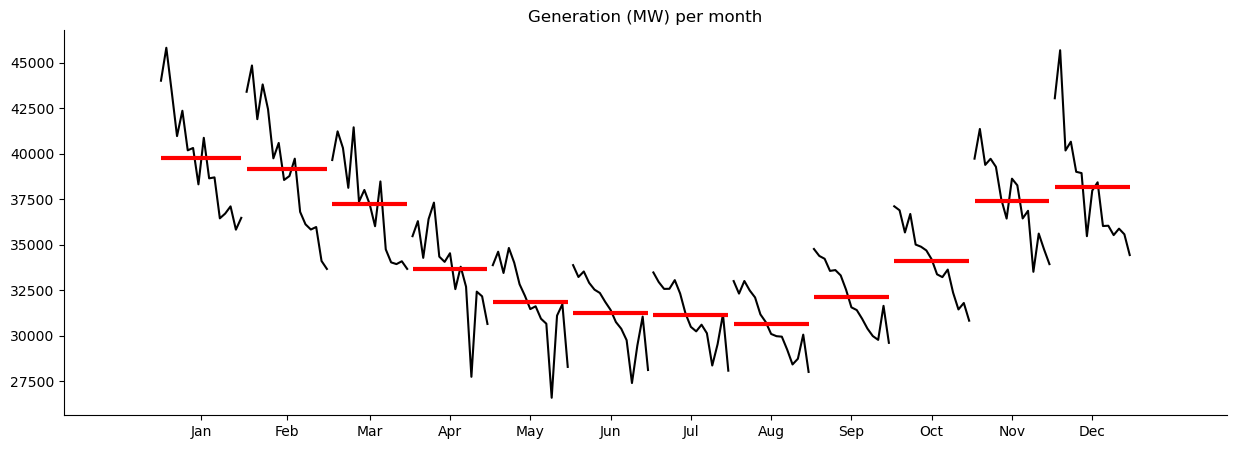

In [8]:
#monthly generation, using code from time series notebook
plt.figure(figsize=(15, 5))

month_plot(g_monthly['GENERATION'], ax=plt.gca())

plt.title("Generation (MW) per month")
sns.despine()
plt.show()

From the plot, it can be seen there is a general downward trend across the years for each of the months. The red line shows the average for that month across all years.

There are especially deep drops in energy generation in April and May of 2020, which was reflected in the previous plot. This makes sense, since according to <a href="https://www.metoffice.gov.uk/about-us/press-office/news/weather-and-climate/2020/2020-round-up">MetOffice</a> (the national meteorological service for the UK), April 2020 was the sunniest month on record since 1919.

In [24]:
monthly_mean_diff = ((g_monthly.groupby(g_monthly.index.month).mean()['GENERATION'] - g_monthly['GENERATION'].mean()) / g_monthly['GENERATION'].mean())*100
monthly_mean_diff

DATETIME
1     14.388548
2     12.610495
3      7.083188
4     -3.197141
5     -8.285062
6    -10.119846
7    -10.467307
8    -11.901998
9     -7.614466
10    -1.837821
11     7.671828
12     9.869645
Name: GENERATION, dtype: float64

In [26]:
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_tickformat = '.0%',
    title= "% difference from average monthly total generation",
    xaxis_title="month",
    yaxis_title="percent difference",
    showlegend=False,
)
fig.show()

The bar plot shows that April and October seem to be the transition months, as they are the two months closest to the monthly average energy generation. The deviation from the mean steadily increases over the winter months, and steadily decreases through the summer months, which reflects the patterns we observed in previous plots.

Before we begin any modelling, we'll first check for stationarity. Stationarity is a fundamental assumption of time series modelling. It means the fundamental statistical characteristics of the data (ie, the mean, variance, and autocorrelation) remain stationary over time, or that a shift in time doesn't cause a change in the shape of its distribution. This helps with interpretability (ie, is an observation in the data a part of an existing pattern? Or merely a random occurence?). 

Three ways to check for stationarity are:
1) the KPSS test

2) decomposition (ie, separating the data into trends, seasonality, and residuals, then plotting the residuals to check for normal distribution)

3) plotting rolling mean and standard deviation

Let's start with the KPSS test.

In [27]:
from statsmodels.tsa.stattools import kpss

In [28]:
#H0: the null hypothesis for the test is that the data is stationary
#H1: the alternate hypothesis for the test is that the data is not stationary

def perform_kpss_test(df: pd.DataFrame):
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKPSS test')
    print('---'*15)
    print(f'KPSS Statistic: {kpss_stat}')
    print(f'p-value: {p_value}')
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

perform_kpss_test(g_monthly['GENERATION'])


KPSS test
---------------------------------------------
KPSS Statistic: 1.5458938430178846
p-value: 0.01
Number of lags used: 7
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


/var/folders/j5/0__sh29d4jb7tpc11thjxmv00000gn/T/ipykernel_70044/693250055.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The p-value is 0.01, which is less than the standard significance level of 0.05. As such, we reject the null hypothesis (ie, the data is likely non-stationary).

To better understand the underlying components of the data, we will create a seasonal decomposition plot, which will visualise the trend, seasonality, and residuals of the data.

In [29]:
from statsmodels.api import tsa

In [30]:
#set model
decomposition = tsa.seasonal_decompose(g_monthly['GENERATION'], model='additive')

g_monthly['Trend'] = decomposition.trend
g_monthly['Seasonal'] = decomposition.seasonal
g_monthly['Residual'] = decomposition.resid

In [31]:
import plotly.graph_objs as go

In [35]:
#plot decomposition with code from time series notebook


cols = ['Trend', 'Seasonal', 'Residual']

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=g_monthly.index, y=g_monthly[col]),
        row=i+1, 
    col=1
    )

fig.update_layout(height=800, width=1100, showlegend=False)
fig.show()
plt.savefig('g_monthly_decomposition.png', dpi=300)

<Figure size 640x480 with 0 Axes>

The Trend plot shows a clear downward trend, which matches the overall pattern we saw in the "Total monthly generation from 2009 to 2024" plot earlier. 

The Seasonal plot also reflects the summer peaks and winter troughs we saw in the monthly plots above.

The Residual plot shows a some inconsistent variance, along with several outliers (ie, there is some heteroscedasticity). 

Though we already conducted further research for the sudden drop in energy generation in April 2020, we might also inspect the other outliers for December 2010 and December 2015. According to the Met Office, December 2010 was the <a href="https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2010/snow-and-low-temperatures-december-2010---met-office.pdf">coldest December in 100 years</a>, with exceptionally low temperatures putting increased pressure on utilities. Conversely, December 2015 was, at the time, the <a href="https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2015/exceptional-warmth-december-2015---met-office.pdf">warmest on record</a> for central England. As such, it makes sense why 2010 saw a sharp increase in energy generation, while there was an unusual drop in energy generation in the winter of 2015.

It's worth plotting the residuals to see if they are normally distributed.

<Axes: >

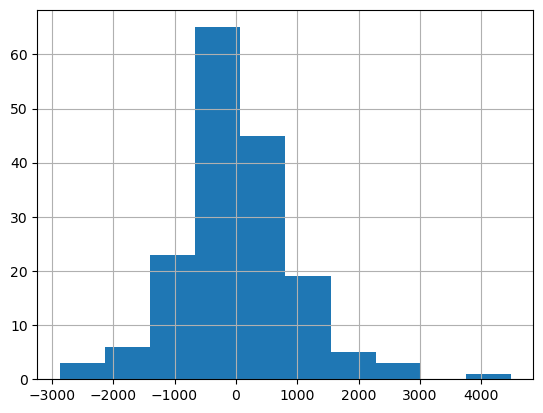

In [36]:
decomposition.resid.hist()

The residuals are somewhat normally distributed, with a slight right skew. This means that most but not all of the data's patterns are captured in the trend and seasonality plots. 

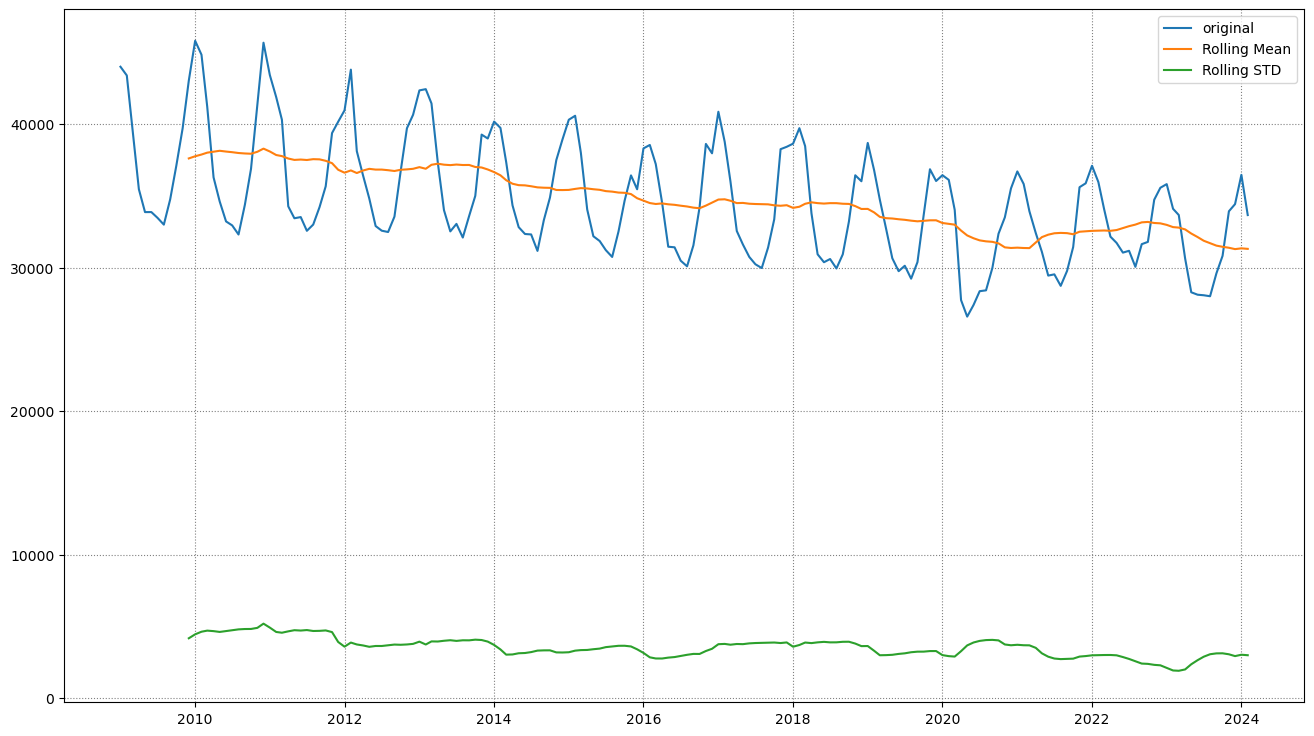

In [37]:
#code from time series notebook for rolling mean plot

df = g_monthly['GENERATION']

def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int):
    df=dataframe.copy()
    roll_mean=df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()

    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')
    ax.plot(df, label="original")
    ax.plot(roll_mean, label='Rolling Mean')
    ax.plot(roll_std, label='Rolling STD')

    ax.legend(loc='upper right')
    plt.grid(linestyle=":", color='grey')
    plt.show()

plot_rolling_mean_and_std(df, window=12)

The rolling mean and standard deviation plot confirms the non-stationarity of the data (while the rolling standard deviation is relatively flat, the rolling mean shows a downward trend (ie, it is not constant over time).

Given the non-stationary data, there are additional plots to help determine the subsequent parameter adjustments to be made in our modelling. The three main parameters in the SARIMA model are:

*p: autoregressive component*

*d: differencing component*

*q: moving average component*


To determine those components, we can use:

1) differencing (ie, .diff()) the data helps make the time series more stationary by separating trend and seasonality components to help determine the differencing component (d)
2) ACF and PACF plots examine significant spikes at lag values, helping to identify the order of the autoregressive component (p) and the moving average component (q)

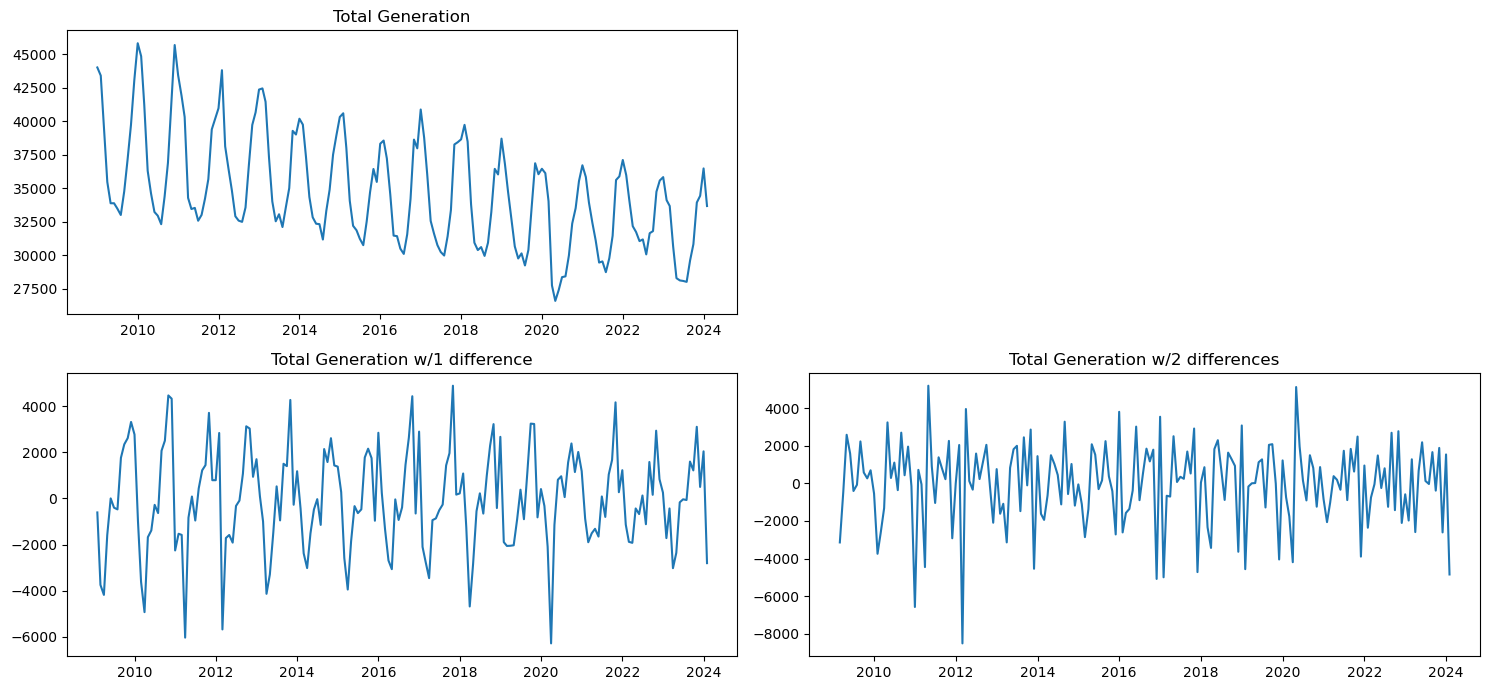

In [38]:
#differencing plots

fig, axs = plt.subplots(2,2, figsize = (15, 7))

#total generation
axs[0, 0].plot(g_monthly['GENERATION'])
axs[0, 0].set_title('Total Generation')

#hide the second subplot
axs[0, 1].axis('off')

#1 difference
axs[1, 0].plot(g_monthly['GENERATION'].diff())
axs[1, 0].set_title('Total Generation w/1 difference')

#2 differences
axs[1, 1].plot(g_monthly['GENERATION'].diff().diff())
axs[1, 1].set_title('Total Generation w/2 differences')

plt.tight_layout()
plt.show()

We can see that the data becomes stationary around zero after 1 difference, indicating a year-on-year seasonality (ie, the trend flattens and the variance looks centered around zero, with relatively constant peaks and troughs). The variance becomes greater (ie, the y-axis scale stretches to -8000) with 2 differences. As such, we will set trend differencing to d=1.

We will move onto plotting the autocorrelation and partial autocorrelation (ie, removing the correlations effect from shorter lags).

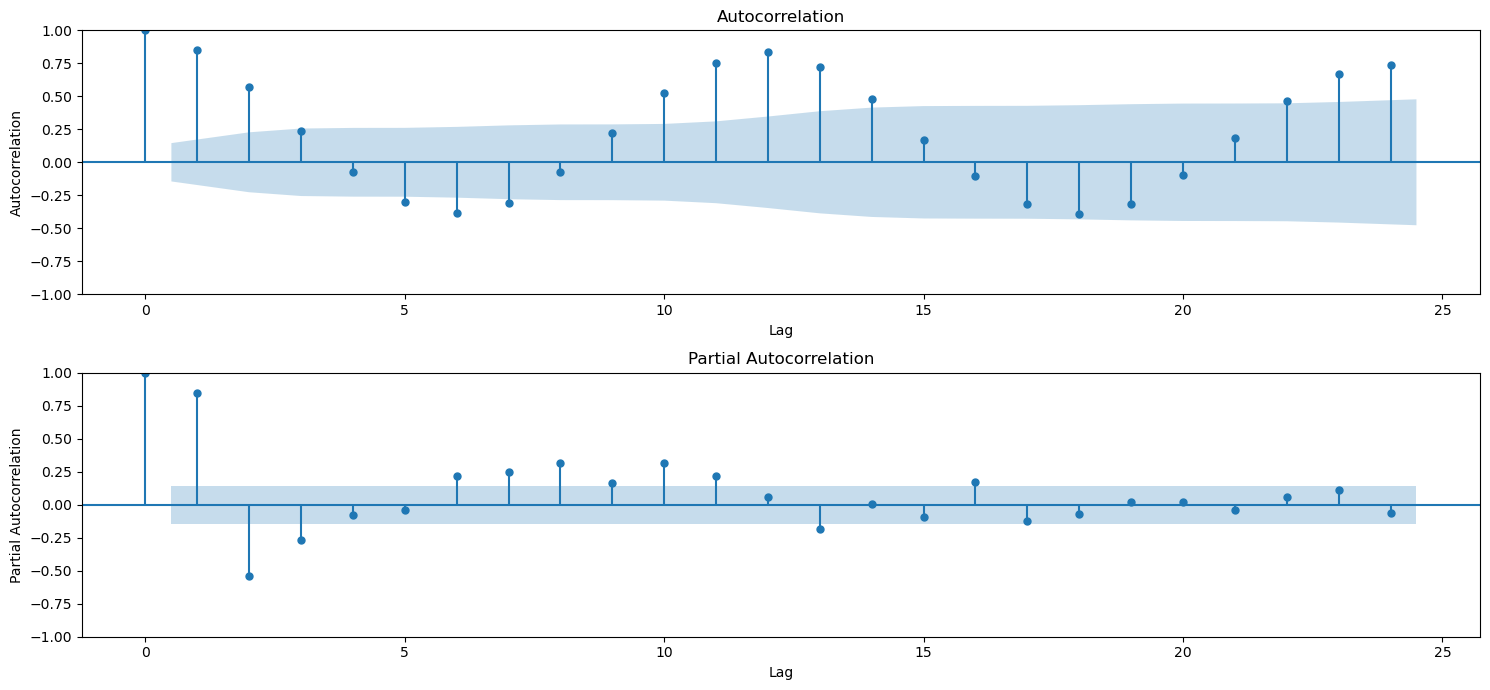

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,1, figsize = (15, 7))

#plot ACF
plot_acf(g_monthly['GENERATION'], lags=24, ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('Autocorrelation')

#plot PACF
plot_pacf(g_monthly['GENERATION'], lags=24, ax=axs[1], method='ywm')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

In the ACF plot, we can see a significant drop in autocorrelation after Month 3. It rises again in Months 10-14, and Months 23-24. Since there is one peak and one valley every 6 months, we can set the seasonal period parameter s=12. Since the first significant lag occurs after 3 months, we can set p=3.

Within PACF, we can see that, although correlation decreases after Month 3, there is still some negative autocorrelation in Month 13, and some positive correlation in Month 16. Since the there is a drop in correlation after the second month, we can set q=2.

In summary:

p=3

q=2

d=1

s=12

Next, we can plot the ACF and PACF again to confirm the seasonality component (ie, add .diff(12) to the hyperparameters), to get a sense of what our P, D, and Q hyperparameters should be.

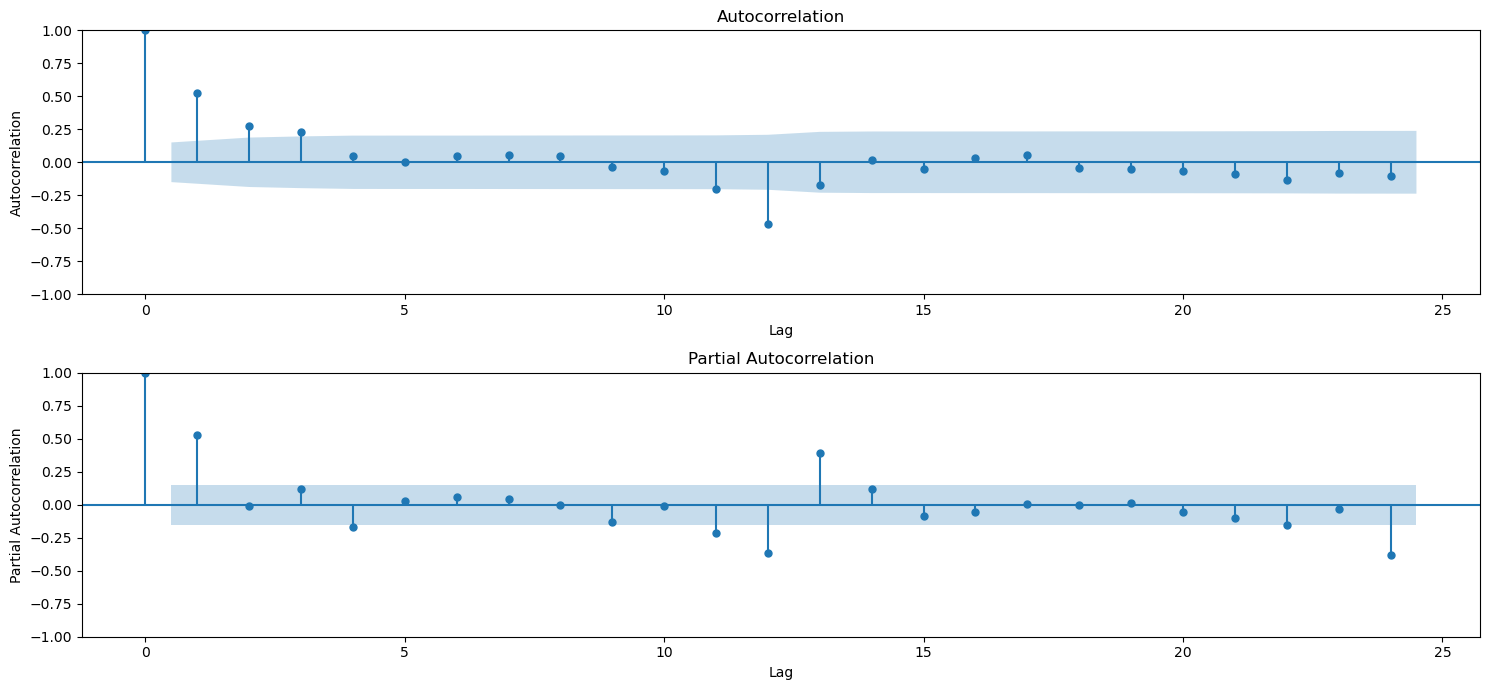

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2,1, figsize = (15, 7))

#plot ACF
#.diff(12) for seasonality, .dropna() because due to .diff, first row will always be empty
plot_acf(g_monthly['GENERATION'].diff(12).dropna(), lags=24, ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('Autocorrelation')

#plot PACF
plot_pacf(g_monthly['GENERATION'].diff(12).dropna(), lags=24, ax=axs[1], method='ywm')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

With the .diff(12), the data has become more stable (ie, most of the months are now within the shaded region of the plot). There is a drop in both plots after the first lag. As such, we can start with the simplest model and set the hyperparameter values to 1.

In summary:

P = 1

D = 1

Q = 1

Given the increase in stationarity with the .diff(12), we might not get the optimal results with an ARIMA model, and may achieve better results with a SARIMA (seasonal ARIMA) model. We will start with a simple linear regression model, before attempting the SARIMA model.

As the first step of modelling, we'll create a train and test split of the data.

>>*While there is an scikit-learn function for TimeSeriesSplit, using that method splits the data on a row level, without using a date or time boundary. In a time series split tutorial from automated data visualisation company Rasgo, the start and end dates of the dataset are used as an alternative method to creating the train/test split. I've borrowed some of the code from <a href="https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split">their tutorial</a> below for the train and test split of the energy generation data. We will come back to TimeSeriesSplit later on.*

### INITIAL MODELLING

#### Train-Test Split

Time series modelling is unique in the structure around train/test splitting, the train/test split cannot with random selection of rows as with other datasets. This is because of the ordering of time. A row of Train data with a future timestamp cannot be used to predict a row of Test data with a past timestamp. 

As such, we need to split the Train and Test portions of data along the chronological path only (eg, the first 75% of timestamps are the Train set, and the last 25% of timestamps are the Test set).

In [41]:
#finding the first and last timestamps in the dataset

min_date = g_monthly.index.min()
max_date = g_monthly.index.max()

print("Min:", min_date, "Max:", max_date)

Min: 2009-01-01 00:00:00+00:00 Max: 2024-02-01 00:00:00+00:00


In [42]:
#delineating the cutoff date for the Train/Test split

train_percent = 0.75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between

train_cutoff

Timestamp('2020-04-24 18:00:00+0000', tz='UTC')

#### Linear Regression Model (Auto-regressive)

Our baseline model will focus on the Generation column as the dependent variable. If we were to use the DATETIME index as the independent variable, we would only have 1 feature--the Generation column. With only 1 feature, we would get a beta coefficient of 1, and our model would be 100% accurate. This is great in terms of accuracy, but not great in terms of predictive powers for future unseen data. 

To help solve for this, we can "lag" the data using the .shift() method to select a number of rows by which to lag the datapoint and create a new dependent variable (ie, given the current generation at this timestamp, how accurately can the model predict the amount of energy generated one timestamp ahead).

In [43]:
#create the train and test dataframes
y = g_monthly['GENERATION']
X = g_monthly['GENERATION'].shift(1)
X.dropna(inplace=True) #due to the lag, the first value will be NaN, and thus needs to be dropped
y = y.iloc[1:]

X_train = X[X.index <= train_cutoff]
X_test = X[X.index > train_cutoff]

y_train = y[y.index <= train_cutoff]
y_test = y[y.index > train_cutoff]

In [44]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

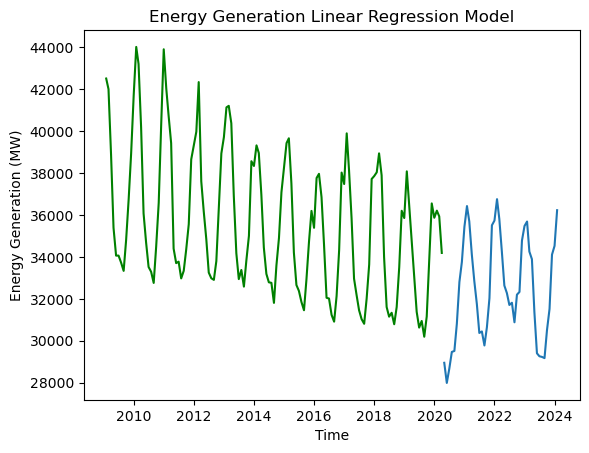

In [45]:
#instantiate the model
linreg = LinearRegression()

#fit the model
linreg.fit(X_train.values.reshape(-1, 1), y_train)

#predict
y_train_pred = linreg.predict(X_train.values.reshape(-1, 1))
y_test_pred = linreg.predict(X_test.values.reshape(-1, 1))

#visualise
plt.plot(pd.DataFrame(y_train_pred, index = y_train.index, columns = ['train_pred']), color='green')
plt.plot(pd.DataFrame(y_test_pred, index = y_test.index, columns = ['test_pred']))
plt.xlabel('Time')
plt.ylabel('Energy Generation (MW)')
plt.title('Energy Generation Linear Regression Model');

In [51]:
#evaluating the model

#root mean squared error (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

#evaluate
print(f'The R2 score (Train): {r2_score(y_train, y_train_pred)}')
print(f'The R2 score (Test): {r2_score(y_test, y_test_pred)}')
print(f'The RMSE score (Train - abs): {train_rmse}')
print(f'The RMSE score (Test - abs): {test_rmse}')

The R2 score (Train): 0.697249181459682
The R2 score (Test): 0.7080173928357549
The RMSE score (Train - abs): 2171.1028863756446
The RMSE score (Test - abs): 1570.5345752400187


Model evaluation: 

R2: the Train and Test scores are quite close to each other, which indicates the model generalises well to unseen data. That said, 0.7 is not an especially high score (if 1.0 is perfect accuracy), leaving room for improvement. It can serve as a baseline comparison for other models (eg, SARIMA/SARIMAx).

RMSE: the predictive value of RMSE scores depends on various factors, including the scale and context of the data. An RMSE of 1570.53 means that, on average, the model's predictions are off by approximately 1570.53 units (in this case, MW) from the actual values. To provide context for the values, we should check the mean Generation column.

In [50]:
g_monthly_mean = g_monthly['GENERATION'].mean()
g_monthly_mean

34755.11188674891

Reviewing the mean, the model's predictions have an average error margin of 4.5% relative to the mean monthly Generation. 

In [54]:
train_rmse_perc = (train_rmse/g_monthly_mean)*100
test_rmse_perc = (test_rmse/g_monthly_mean)*100

print(f'The RMSE score (Train - %): {train_rmse_perc}')
print(f'The RMSE score (Test - %): {test_rmse_perc}')

The RMSE score (Train - %): 6.246859148232009
The RMSE score (Test - %): 4.518859212301419




We can also calculate the MAPE (Mean Absolute Percentage Error). MAPE gauges the average percentage difference between the predicted and the actual values to provide a relative measure of accuracy.

In [77]:
from sklearn.metrics import mean_absolute_percentage_error

def mean_absolute_percentage_error(y_train, y_train_pred):
    
    error_train = y_train - y_train_pred
    absolute_percentage_error = np.abs(error_train/y_train)
    mape = absolute_percentage_error.mean() * 100
    
    return mape


train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print(f"Train MAPE on the difference: {round(train_mape, 2)}%")

Train MAPE on the difference: 4.91%


In [78]:
def mean_absolute_percentage_error(y_test, y_test_pred):
    
    error_test = y_test - y_test_pred
    absolute_percentage_error = np.abs(error_test/y_test)
    mape = absolute_percentage_error.mean() * 100
    
    return mape


test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Test MAPE on the difference: 4.14%


The Train MAPE and the Test MAPE are similar to the RMSE score. This suggests that, on average, the model's predictions are fairly accurate, with errors typically less than 5% of the actual values. We can also use MAPE to compare the performance of other models later on.

### **NEXT STEPS**

**Additional modelling:**

- SARIMA and SARIMAx (to include factors external to the time series, such as population growth)

- XGboost or Prophet model (for additonal model performance comparison)

- re-running advanced EDA and modelling for individual energy sources

### **SUMMARY**

- Creating the monthly dataframe extract has helped remove some of the "noise" from the data during advanced EDA and modelling.
- Advanced EDA showed clear seasonality (eg, peak energy generation in winter months, and lower energy generation in summer months). Peak energy generation occurs in January, with August exhibiting the lowest energy usage per year.
- Overall, there is a clear downward trend in historical energy generation.
- The initial linear regression model showed an accuracy score of ~70%. While this leaves room for improvement, the closeness of the Train and Test accuracy scores indicates the model generalises well to unseen data.
- The .diff(), ACF, and PACF plots in Advanced EDA have helped us select hyperparameters for additional modelling.
- By exploring other models for increased accuracy (eg, SARIMA/SARIMAx and XGboost), we can finalise a model to expand the forecasting to other individual energy sources from the dataset. While it is good to model the future total energy generation in 2050, forecasting generation on a granular level (by individual energy source) may provide more useful insights for use by UK policy and decision makers with regards to opportunities and challenges during the energy transition, and  better reflect growth of renewable energy use without trends being skewed by the transition away from fossil fuels (and subsequent decline in energy generation).